In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import pickle
import re
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

2023-03-21 20:19:13.207969: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 20:19:14.253084: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-21 20:19:14.253195: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-21 20:19:14.253205: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
lines= pd.read_table('datasets/por-eng/por.txt', names=['eng', 'por', '_'])
lines.shape

(188206, 3)

In [3]:
lines.sample(5)

,eng,por,_
170572,It's a pity that you don't know how to dance.,É uma pena tu não saberes dançar.,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
63953,This company is my life.,Essa empresa é a minha vida.,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
132424,Living in Japan is very expensive.,Morar no Japão é muito caro.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
129181,What kind of music does Tom like?,De que tipo de música Tom gosta?,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
2725,I'll fix it.,Irei consertá-lo.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [4]:
# Lowercase all characters
lines.eng=lines.eng.apply(lambda x: x.lower())
lines.por=lines.por.apply(lambda x: x.lower())

# Remove quotes
lines.eng=lines.eng.apply(lambda x: re.sub("'", '', x))
lines.por=lines.por.apply(lambda x: re.sub("'", '', x))
exclude = set(string.punctuation) # Set of all special characters

# Remove all the special characters
lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.por=lines.por.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines.eng=lines.eng.apply(lambda x: x.translate(remove_digits))
lines.por = lines.por.apply(lambda x: x.translate(remove_digits))

# Remove extra spaces
lines.eng=lines.eng.apply(lambda x: x.strip())
lines.por=lines.por.apply(lambda x: x.strip())
lines.eng=lines.eng.apply(lambda x: re.sub(" +", " ", x))
lines.por=lines.por.apply(lambda x: re.sub(" +", " ", x))

# Add start and end tokens to target sequences
lines.por = lines.por.apply(lambda x : 'start_ '+ x + ' _end')

lines.sample(5)

,eng,por,_
112151,i hope tom is home next monday,start_ espero que o tom esteja em casa na próx...,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
40424,i need a good lawyer,start_ eu preciso de um bom advogado _end,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
174640,tom wasnt able to answer any of the questions,start_ tom não era capaz de responder nenhuma ...,CC-BY 2.0 (France) Attribution: tatoeba.org #8...
75809,i dont need a girlfriend,start_ eu não preciso de uma namorada _end,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
18328,the hat is yours,start_ o chapéu é teu _end,CC-BY 2.0 (France) Attribution: tatoeba.org #4...


In [7]:
# Vocabulary of English
all_eng_words=set()
for eng in lines.eng:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

# Vocabulary of Prtuguese 
all_por_words=set()
for por in lines.por:
    for word in por.split():
        if word not in all_por_words:
            all_por_words.add(word)

# Max Length of source sequence
lenght_list=[]
for l in lines.por:
    lenght_list.append(len(l.split(' ')))
max_length_src = np.max(lenght_list)

# Max Length of target sequence
lenght_list=[]
for l in lines.eng:
    lenght_list.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list)

input_words = sorted(list(all_por_words))
target_words = sorted(list(all_eng_words))

# Calculate Vocab size for both source and target
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_por_words)
num_decoder_tokens += 1 # For zero padding

# Create word to token dictionary for both source and target
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

# Create token to word dictionary for both source and target
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

lines = shuffle(lines)
lines.head(5)

,eng,por,_
174794,whos that sitting next to you in this picture,start_ quem está sentado ao seu lado nesta fot...,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
73331,what a beautiful morning,start_ que belo dia _end,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
172660,the teacher wrote something on the blackboard,start_ o professor escreveu algo na lousa _end,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
86758,tom has been very tolerant,start_ tom tem sido muito tolerante _end,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
1346,come along,start_ venha conosco _end,CC-BY 2.0 (France) Attribution: tatoeba.org #5...


2023-03-21 20:21:11.483050: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 20:21:11.514825: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-03-21 20:21:11.514874: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-03-21 20:21:11.515256: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neur

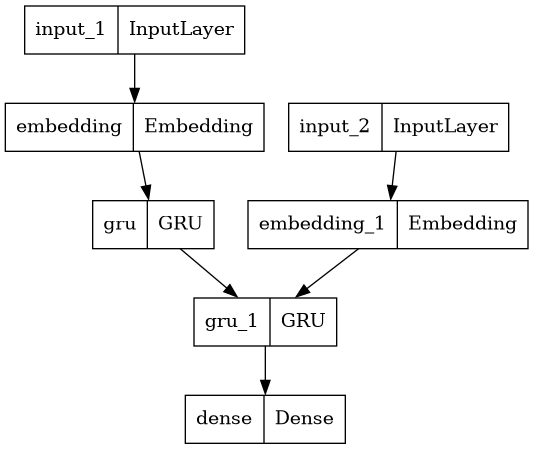

In [8]:
with open('../01_Word_Tokenizer/models/PORT_GRU/char_to_index.pkl', 'rb') as fp:
    char_to_index = pickle.load(fp)
    
port_model = load_model('../01_Word_Tokenizer/models/PORT_GRU/por_enc_dec', compile=True)
plot_model(port_model)

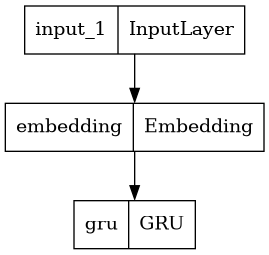

In [9]:
inp = port_model.input[0]
outputs = port_model.layers[4].output  
word_encoder_model = Model(inp, outputs)

plot_model(word_encoder_model)

In [10]:
max_length_word = len(max(all_por_words, key=len))

In [11]:
def generate_batch_pt(X, batch_size=128):
    ''' Generate a batch of data '''
    while True:
        # iterate from batch to batch
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_word),dtype='float32')
            # get the batch elements 
            for i, raw_word in enumerate(X[j:j+batch_size]):
                input_word = '<' + raw_word + '>'
                for t, char in enumerate(input_word):
                    encoder_input_data[i, t] = char_to_index[char] # encoder input seq
            yield(encoder_input_data)

            
def encode_word(encoder_model, input_words):
    train_gen = generate_batch_pt(input_words, batch_size=len(input_words))
    input_seq = next(train_gen)
    # Encode the input as state vectors.
    _, encoded_data = encoder_model.predict(input_seq, verbose=0)

    return encoded_data


unknown = pd.Series(['nintendo', 'nontendo',  'arretado', 'estrombofone','tankar', '_end'])
encoded_data = encode_word(word_encoder_model, unknown)

In [12]:
# Train - Test Split
X, y =  lines.por, lines.eng
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape, X_test.shape)

(150564,) (37642,)


In [20]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = [];
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                words = input_text.split()
                encoder_input_data.add([encode_word(word_encoder_model, words)])
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)


In [21]:
latent_dim = 50

In [22]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [23]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# Use a softmax to generate a probability distribution over the target vocabulary for each time step
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

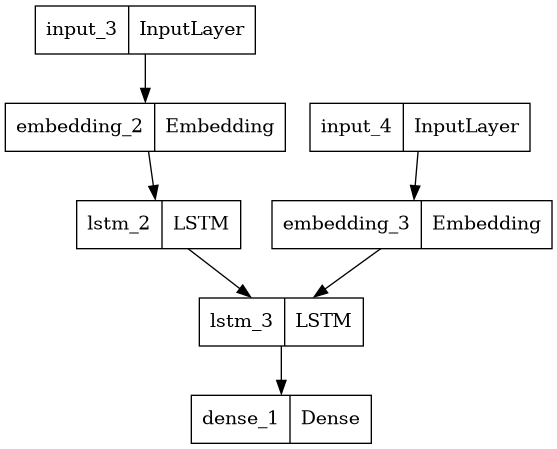

In [24]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

plot_model(model)

In [25]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 50

In [26]:
model.fit(
    generate_batch(X_train, y_train, batch_size = batch_size),
    steps_per_epoch = train_samples//batch_size,
    epochs=epochs,
    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
    validation_steps = val_samples//batch_size
)

TypeError: unhashable type: 'list'

In [ ]:
model.save_weights('files/model/nmt_weights.h5')
model.load_weights('files/model/nmt_weights.h5')

In [ ]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs2] + decoder_states2)

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char
        
        # Exit condition: either hit max length or find stop token.
        if (sampled_char == '_END' or len(decoded_sentence) > 50):
            stop_condition = True
        
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        # Update states
        states_value = [h, c]
    
    return decoded_sentence

In [ ]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [ ]:
for _ in range(15):
    k+=1
    (input_seq, actual_output), _ = next(train_gen)
    decoded_sentence = decode_sequence(input_seq)
    print('Input English sentence:', X_train[k:k+1].values[0])
    print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
    print('Predicted Marathi Translation:', decoded_sentence[:-4])